# ML-CUP25: End-to-end Pipeline mit `network`
In diesem Notebook reproduzieren wir die Schritte aus dem MONK-Notebook für das ML-CUP25-Trainingsset:
- Laden & Vorbereiten der Daten (CSV)
- Einfaches Train/Val/Test-Training mit Lernkurven (MSE, R²)
- Nested Cross-Validation mit Grid Search (outer K-Folds, inner K-Folds)
- Visualisierung der Outer-Fold-Ergebnisse und der Grid-Auswahl
- Lernkurven für die beste Konfiguration

## Imports und Hilfsfunktionen
Wir verwenden ausschließlich NumPy, Pandas, Matplotlib und die `network`-Bausteine. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from network.dataset import Dataset
from network.dataloader import DataLoader
from network.model import Model
from network.linear import LinearLayer
from network.relu import ReLU
from network.mse import MSELoss
from network.adam import AdamWOptimizer

def r2_score_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = y_true.astype(np.float64)
    y_pred = y_pred.astype(np.float64)
    y_mean = y_true.mean()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    if ss_tot == 0:
        return 0.0
    return float(1.0 - ss_res / ss_tot)

# Mean Euclidean Error (MEE) gemäß Wettbewerbsdefinition
# E_MEE = (1/l) * sum_p ||o_p - t_p||_2
# (auf Originalskala der Targets; wir standardisieren Targets NICHT)
def mee_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    diffs = y_pred.astype(np.float64) - y_true.astype(np.float64)
    dists = np.sqrt(np.sum(diffs ** 2, axis=1))  # L2 je Pattern über 4 Targets
    return float(np.mean(dists))

def standardize_fit(X: np.ndarray):
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True) + 1e-8
    return mu, sigma

def standardize_apply(X: np.ndarray, mu: np.ndarray, sigma: np.ndarray):
    return (X - mu) / sigma

def build_model(input_dim: int, hidden_sizes, output_dim: int):
    layers = []
    in_dim = input_dim
    for h in hidden_sizes:
        layers.extend([LinearLayer(in_dim, h), ReLU()])
        in_dim = h
    layers.append(LinearLayer(in_dim, output_dim))
    return Model(*layers)

def make_loader(x, y, batch_size, shuffle):
    return DataLoader(Dataset(x, y), batch_size=batch_size, shuffle=shuffle)

# Helfer: Vorhersagen in Batches (ohne Targets nötig)
def predict_in_batches(model: Model, X_s: np.ndarray, batch_size: int) -> np.ndarray:
    loader = make_loader(X_s, np.zeros((X_s.shape[0], 1), dtype=np.float32), batch_size=batch_size, shuffle=False)
    preds = []
    for xb, _ in loader:
        yp = model.forward(xb)
        preds.append(yp)
    return np.concatenate(preds, axis=0)

## Daten laden (ML-CUP25-TR.csv)
Die CSV enthält:
- Erste Spalte: `ID`
- Feature-Spalten: alle Spalten nach `ID` bis zu den letzten 4
- Zielvariablen: die letzten 4 Spalten (`TARGET_1..4`)

Wir lesen die Datei mit `pandas.read_csv` und `comment="#"` (ignoriert Kopf-Kommentare).

In [36]:
# CSV einlesen
df = pd.read_csv('ML-CUP25-TR.csv', header=None, comment='#')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,-6.925642,-6.093158,-9.149763,-5.918488,4.391259,-1.059304,-5.031085,-6.932177,-5.805652,7.147028,4.555533,-5.694865,6.554997,10.688732,15.416160,-7.535628
1,2,-5.649870,-7.650998,-10.407383,-7.864047,3.790306,-1.673732,-8.493233,-8.143588,-9.447557,10.790796,6.266211,-5.551301,12.342252,-8.135250,23.787661,-3.270978
2,3,15.985886,14.192953,24.466835,12.551305,-7.788409,0.557977,23.145951,20.031774,14.516358,-21.024198,-10.410913,12.061133,28.542661,-14.132383,-56.408372,1.892238
3,4,12.774004,10.156462,18.588934,8.346695,-5.245173,-0.199274,14.500231,12.608063,12.411055,-15.479452,-8.871887,6.703585,20.253500,9.525402,-0.673842,40.295464
4,5,-4.019226,-4.043457,-5.095354,-3.147125,0.725466,-0.477673,-4.025913,-0.995364,-3.491760,3.385533,1.838361,-4.271710,-3.588910,6.050010,1.198489,-11.677909


In [37]:
# Aufteilen in ID, X, y
ID = df.iloc[:, 0].to_numpy()
X  = df.iloc[:, 1:-4].astype(np.float32).to_numpy()
y  = df.iloc[:, -4:].astype(np.float32).to_numpy()
X.shape, y.shape

((500, 12), (500, 4))

## Einfaches Train/Val/Test-Training mit Lernkurven
Wir führen ein klassisches Training mit festem Split durch:
- Standardisierung der Features anhand des Trainingssplits (ohne Leakage).
- Modell: zwei versteckte Schichten.
- Tracking: Train/Val MSE und Val-R² je Epoche.

In [ ]:
# Fester Split
n_total = X.shape[0]
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)

X_train, y_train = X[:n_train],               y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val],  y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:],         y[n_train+n_val:]

# Standardisierung nur basierend auf Training
mu, sigma = standardize_fit(X_train)
X_train_s = standardize_apply(X_train, mu, sigma)
X_val_s   = standardize_apply(X_val,   mu, sigma)
X_test_s  = standardize_apply(X_test,  mu, sigma)

# Dataloader
train_loader = make_loader(X_train_s, y_train, batch_size=32, shuffle=True)
val_loader   = make_loader(X_val_s,   y_val,   batch_size=32, shuffle=False)

# Modell + Training
input_dim  = X_train_s.shape[1]
output_dim = y_train.shape[1]
model = build_model(input_dim, hidden_sizes=(32,), output_dim=output_dim)
loss_fn = MSELoss()
optimizer = AdamWOptimizer(model, learning_rate=0.003, weight_decay=0.0005)

num_epochs = 150
train_loss_history = []
val_loss_history   = []
val_r2_history     = []

for epoch in range(num_epochs):
    # Train
    train_losses = []
    for xb, yb in train_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        g  = loss_fn.backward()
        model.backward(g)
        optimizer.step()
        train_losses.append(l)
    # Val
    val_losses = []
    preds = []
    trues = []
    for xb, yb in val_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        val_losses.append(l)
        preds.append(yp)
        trues.append(yb)
    mean_train = float(np.mean(train_losses))
    mean_val   = float(np.mean(val_losses))
    p_full = np.concatenate(preds, axis=0)
    t_full = np.concatenate(trues, axis=0)
    val_r2 = r2_score_np(t_full, p_full)
    train_loss_history.append(mean_train)
    val_loss_history.append(mean_val)
    val_r2_history.append(val_r2)
    print(f"Epoch {epoch+1:03d} | TrainLoss={mean_train:.4f} | ValLoss={mean_val:.4f} | ValR2={val_r2:.4f}")

# Testbewertung
test_loader = make_loader(X_test_s, y_test, batch_size=32, shuffle=False)
test_losses = []
preds = []
trues = []
for xb, yb in test_loader:
    yp = model.forward(xb)
    l  = loss_fn.forward(yp, yb)
    test_losses.append(l)
    preds.append(yp)
    trues.append(yb)

p_full = np.concatenate(preds, axis=0)
t_full = np.concatenate(trues, axis=0)
test_loss = float(np.mean(test_losses))
test_r2 = r2_score_np(t_full, p_full)
test_mee = mee_np(t_full, p_full)
print(f"TestLoss={test_loss:.4f} | TestR2={test_r2:.4f} | TestMEE={test_mee:.4f}")

Epoch 001 | TrainLoss=328.2741 | ValLoss=285.9201 | ValR2=0.2401
Epoch 002 | TrainLoss=240.3704 | ValLoss=209.4016 | ValR2=0.4461
Epoch 003 | TrainLoss=194.9202 | ValLoss=203.7062 | ValR2=0.4651
Epoch 004 | TrainLoss=191.6827 | ValLoss=197.8191 | ValR2=0.4775
Epoch 005 | TrainLoss=187.6208 | ValLoss=196.4516 | ValR2=0.4814
Epoch 006 | TrainLoss=189.2464 | ValLoss=196.6105 | ValR2=0.4800
Epoch 007 | TrainLoss=189.9694 | ValLoss=194.8109 | ValR2=0.4889
Epoch 008 | TrainLoss=186.4590 | ValLoss=190.5593 | ValR2=0.4983
Epoch 009 | TrainLoss=181.5365 | ValLoss=191.0682 | ValR2=0.4978
Epoch 010 | TrainLoss=180.0492 | ValLoss=189.2016 | ValR2=0.5010
Epoch 011 | TrainLoss=182.1368 | ValLoss=187.0093 | ValR2=0.5093
Epoch 012 | TrainLoss=176.7640 | ValLoss=184.2031 | ValR2=0.5190
Epoch 013 | TrainLoss=175.7795 | ValLoss=183.5765 | ValR2=0.5218
Epoch 014 | TrainLoss=175.4135 | ValLoss=182.5363 | ValR2=0.5202
Epoch 015 | TrainLoss=171.1316 | ValLoss=180.4651 | ValR2=0.5271
Epoch 016 | TrainLoss=172

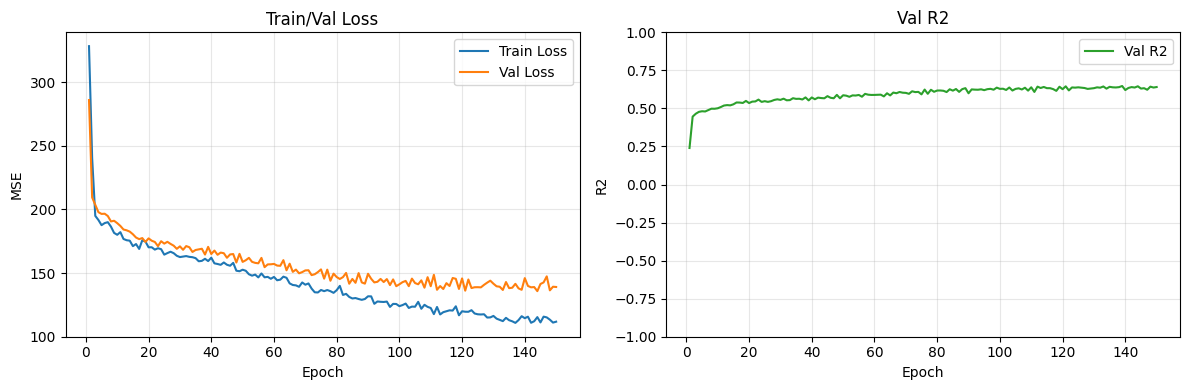

In [39]:
# Lernkurven-Plot (MSE & R2)
epochs = np.arange(1, len(train_loss_history)+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Train/Val Loss'); plt.grid(alpha=0.3); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, val_r2_history, color='tab:green', label='Val R2')
plt.xlabel('Epoch'); plt.ylabel('R2'); plt.title('Val R2'); plt.ylim(-1.0, 1.0); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

## Nested Cross-Validation + Grid Search
Verschachtelte Validierung zur robusten Hyperparameterwahl:
- Outer K-Folds: hold-out Test je Fold.
- Inner K-Folds: Grid Search mit mittlerem inneren Val-Loss als Auswahlkriterium.
- Evaluierung: Test-Loss und Test-R² je Outer-Fold; Mittelwerte am Ende.
- Visualisierungen: Balkendiagramme (Loss/R²), Heatmaps der Auswahlhäufigkeit.

In [ ]:
# Kleines Grid für Nested-CV (deutlich kleinere Netze)
param_grid = {
    'hidden_sizes': [ (8,), (16,), (16,8), (32,) ],
    'learning_rate': [ 0.001, 0.003 ],
    'weight_decay': [ 0.0, 0.0005 ],
    'batch_size': [ 32 ],
    'num_epochs': [ 120 ]
}

grid_configs = []
for hs in param_grid['hidden_sizes']:
    for lr in param_grid['learning_rate']:
        for wd in param_grid['weight_decay']:
            for bs in param_grid['batch_size']:
                for ne in param_grid['num_epochs']:
                    grid_configs.append({
                        'hidden_sizes': hs,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'batch_size': bs,
                        'num_epochs': ne,
                    })

k_outer, k_inner = 5, 3
print(f"Nested CV: outer={k_outer}, inner={k_inner}, grid={len(grid_configs)} → Läufe {k_outer*len(grid_configs)*k_inner}")

N = X.shape[0]
outer_folds = kfold_indices(N, k_outer, seed=123, shuffle=True)
outer_results = []

for ofi in range(k_outer):
    test_idx    = outer_folds[ofi]
    trainval_idx = np.concatenate([outer_folds[j] for j in range(k_outer) if j != ofi])
    X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
    X_test_o,   y_test_o   = X[test_idx],     y[test_idx]
    # Inner folds auf Train+Val
    inner_folds = kfold_indices(X_trainval.shape[0], k_inner, seed=321+ofi, shuffle=True)
    cfg_scores = []
    for cfg in grid_configs:
        inner_vals = []
        for ifi in range(k_inner):
            val_i = inner_folds[ifi]
            tr_i  = np.concatenate([inner_folds[j] for j in range(k_inner) if j != ifi])
            mv, r2v, _, _ = train_one_config_reg(X_trainval[tr_i], y_trainval[tr_i],
                                               X_trainval[val_i], y_trainval[val_i], cfg, seed=42+ifi)
            inner_vals.append(mv)
        cfg_scores.append((cfg, float(np.mean(inner_vals))))
    cfg_scores.sort(key=lambda x: x[1])
    best_cfg, best_inner = cfg_scores[0]
    # Retrain auf komplettem Train+Val und testen auf Outer-Test
    mv, _, best_model, mu_sigma = train_one_config_reg(X_trainval, y_trainval, X_test_o, y_test_o, best_cfg, seed=999)
    te_loss, te_r2 = evaluate_test_reg(best_model, X_test_o, y_test_o, mu_sigma, batch_size=best_cfg['batch_size'])
    # Zusätzliche Wettbewerbsmetrik: MEE
    mu, sigma = mu_sigma
    X_test_s = standardize_apply(X_test_o, mu, sigma)
    p_full = predict_in_batches(best_model, X_test_s, best_cfg['batch_size'])
    te_mee = mee_np(y_test_o, p_full)
    print(f"[Outer {ofi+1}/{k_outer}] best={best_cfg} | inner mean ValLoss={best_inner:.4f} | TestLoss={te_loss:.4f} | TestR2={te_r2:.4f} | TestMEE={te_mee:.4f}")
    outer_results.append({
        'outer_fold': ofi,
        'best_cfg': best_cfg,
        'inner_mean_val_loss': best_inner,
        'test_loss': te_loss,
        'test_r2': te_r2,
        'test_mee': te_mee,
    })

mean_test_loss = float(np.mean([r['test_loss'] for r in outer_results]))
mean_test_r2   = float(np.mean([r['test_r2']   for r in outer_results]))
mean_test_mee  = float(np.mean([r['test_mee']  for r in outer_results]))
print("\n=== Outer-Fold Mittelwerte ===")
print(f"Mean Test Loss: {mean_test_loss:.4f}")
print(f"Mean Test R2  : {mean_test_r2:.4f}")
print(f"Mean Test MEE : {mean_test_mee:.4f}")

Nested CV: outer=5, inner=3, grid=16 → Läufe 240
[Outer 1/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0005, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss=169.7798 | TestLoss=200.1141 | TestR2=0.5221
[Outer 1/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0005, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss=169.7798 | TestLoss=200.1141 | TestR2=0.5221
[Outer 2/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss=175.5077 | TestLoss=160.0263 | TestR2=0.5368
[Outer 2/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss=175.5077 | TestLoss=160.0263 | TestR2=0.5368
[Outer 3/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss=184.5526 | TestLoss=157.4998 | TestR2=0.5176


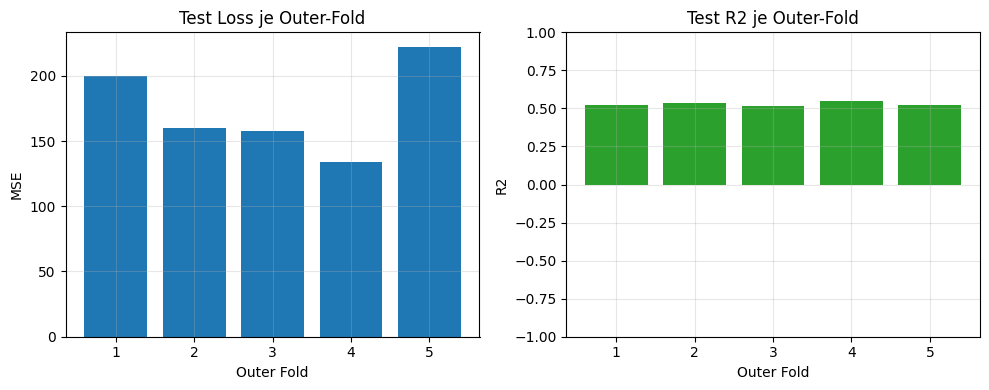

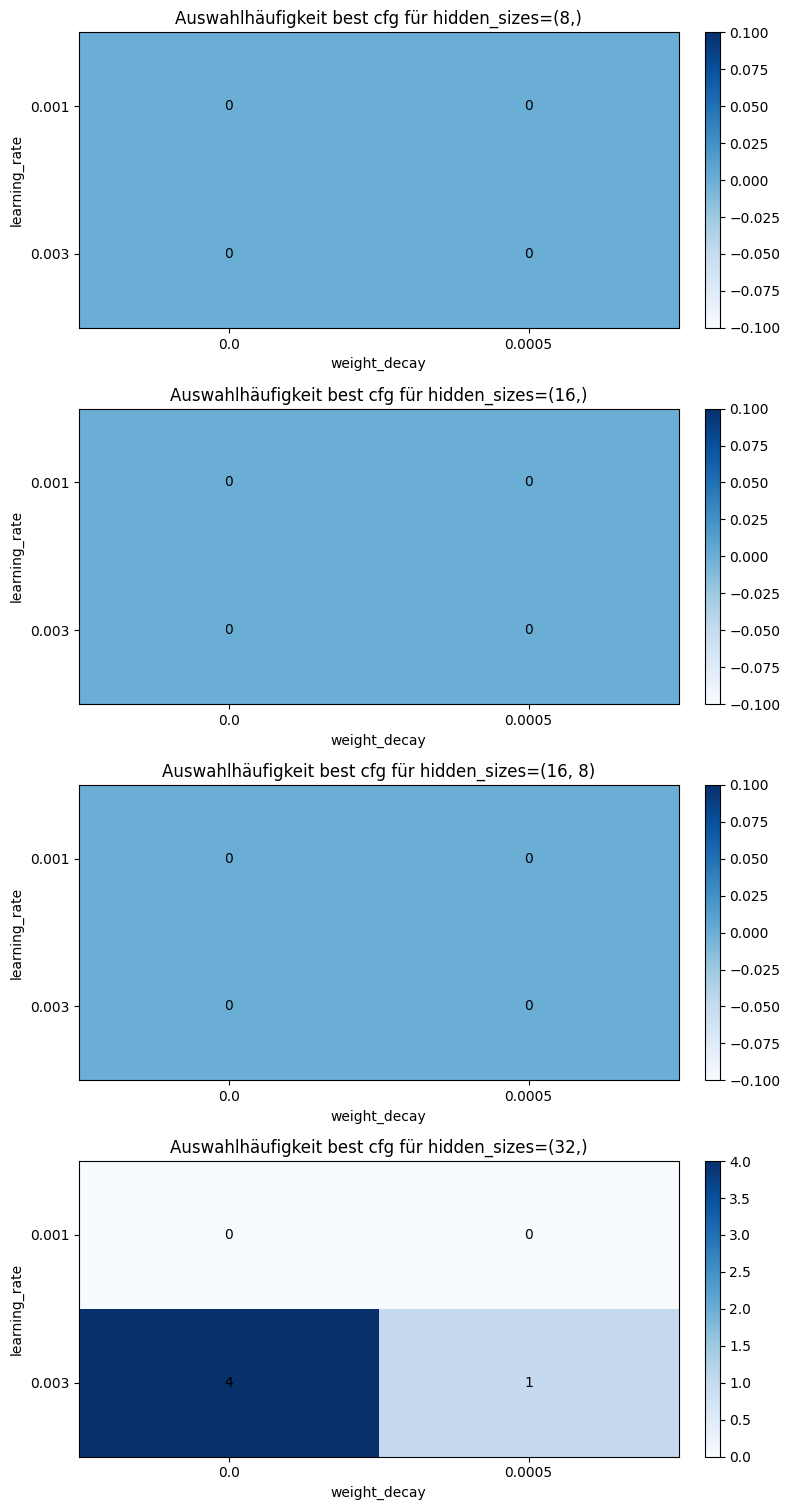

In [ ]:
# Visualisierung der Outer-Fold-Ergebnisse und Grid-Häufigkeiten
from collections import defaultdict

fold_ids = [r['outer_fold']+1 for r in outer_results]
test_losses = [r['test_loss'] for r in outer_results]
test_r2s   = [r['test_r2']  for r in outer_results]
test_mees  = [r['test_mee'] for r in outer_results]

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.bar(fold_ids, test_losses, color='tab:blue')
plt.title('Test Loss je Outer-Fold')
plt.xlabel('Outer Fold'); plt.ylabel('MSE'); plt.grid(alpha=0.3)
plt.subplot(1,3,2)
plt.bar(fold_ids, test_r2s, color='tab:green')
plt.title('Test R2 je Outer-Fold')
plt.xlabel('Outer Fold'); plt.ylabel('R2'); plt.ylim(-1.0, 1.0); plt.grid(alpha=0.3)
plt.subplot(1,3,3)
plt.bar(fold_ids, test_mees, color='tab:orange')
plt.title('Test MEE je Outer-Fold')
plt.xlabel('Outer Fold'); plt.ylabel('MEE (Euclid.)'); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# Heatmap der Auswahlhäufigkeit (hidden_sizes vs (lr, wd))
hs_list = sorted(list({tuple(cfg['hidden_sizes']) for cfg in grid_configs}))
lr_list = sorted(list({cfg['learning_rate'] for cfg in grid_configs}))
wd_list = sorted(list({cfg['weight_decay']  for cfg in grid_configs}))
freq = defaultdict(int)
for r in outer_results:
    cfg = r['best_cfg']
    key = (tuple(cfg['hidden_sizes']), cfg['learning_rate'], cfg['weight_decay'])
    freq[key] += 1

n_rows = len(hs_list)
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 3.8*n_rows), squeeze=False)
for i, hs in enumerate(hs_list):
    mat = np.zeros((len(lr_list), len(wd_list)), dtype=float)
    for rr, lr in enumerate(lr_list):
        for cc, wd in enumerate(wd_list):
            mat[rr, cc] = freq.get((hs, lr, wd), 0)
    ax = axes[i, 0]
    im = ax.imshow(mat, cmap='Blues', aspect='auto')
    ax.set_title(f'Auswahlhäufigkeit best cfg für hidden_sizes={hs}')
    ax.set_xticks(np.arange(len(wd_list))); ax.set_xticklabels([str(wd) for wd in wd_list])
    ax.set_yticks(np.arange(len(lr_list))); ax.set_yticklabels([str(lr) for lr in lr_list])
    ax.set_xlabel('weight_decay'); ax.set_ylabel('learning_rate')
    for rr in range(len(lr_list)):
        for cc in range(len(wd_list)):
            ax.text(cc, rr, f"{int(mat[rr, cc])}", ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

## Lernkurven (best cfg)
Wir trainieren die beste Konfiguration erneut (auf Train+Val aus einem Outer-Fold) und zeichnen Train/Val-Loss sowie Val-R² über die Epochen auf.

## Optimierungen: Early Stopping, erweitertes Grid, per-Target-R² und LR-Decay
Die bisherigen Kurven zeigen, dass das Modell zwar lernt, aber die Generalisierung schwach ist. Wir ergänzen:
- Early Stopping mit Patience zur Vermeidung von Overfitting.
- Größeres Grid (mehr Hidden-Sizes, längere Trainingsdauer) – bei Bedarf reduzieren.
- Per-Target-R², um zu sehen, ob einzelne Ziele besser/schlechter modelliert werden.
- Einfaches Learning-Rate-Decay (halbiere LR, wenn Val-Loss eine Weile nicht besser wird).

Hinweis: Laufzeit steigt. Du kannst die Parameter (Patience, Epochen, Grid) anpassen.

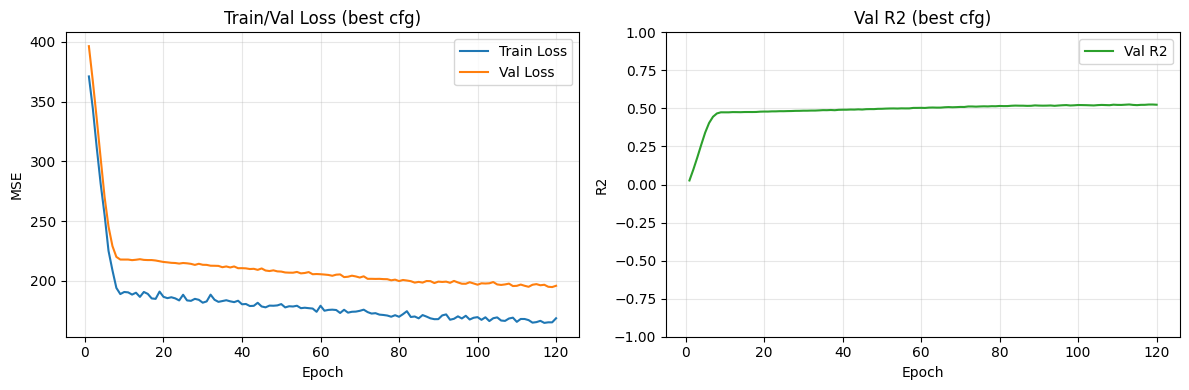

In [42]:
# Neutraining mit best_cfg für Lernkurven
def train_with_hist_reg(X_tr, y_tr, X_val, y_val, cfg, seed=777):
    np.random.seed(seed)
    mu, sigma = standardize_fit(X_tr)
    X_tr_s = standardize_apply(X_tr,  mu, sigma)
    X_val_s= standardize_apply(X_val, mu, sigma)
    model = build_model(X_tr_s.shape[1], cfg['hidden_sizes'], y_tr.shape[1])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=cfg['learning_rate'], weight_decay=cfg['weight_decay'])
    train_loader = make_loader(X_tr_s,  y_tr,  batch_size=cfg['batch_size'], shuffle=True)
    val_loader   = make_loader(X_val_s, y_val, batch_size=cfg['batch_size'], shuffle=False)
    tr_hist, va_hist, r2_hist = [], [], []
    for _ in range(cfg['num_epochs']):
        # Train
        t_losses = []
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()
            t_losses.append(l)
        # Val
        v_losses = []
        preds, trues = [], []
        for xb, yb in val_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            v_losses.append(l)
            preds.append(yp); trues.append(yb)
        tr_hist.append(float(np.mean(t_losses)))
        va_hist.append(float(np.mean(v_losses)))
        p_full = np.concatenate(preds, axis=0)
        t_full = np.concatenate(trues, axis=0)
        r2_hist.append(r2_score_np(t_full, p_full))
    return {'train_loss_history': tr_hist, 'val_loss_history': va_hist, 'val_r2_history': r2_hist}

# Safeguard: erfordert, dass outer_results vorher erzeugt wurden
if len(outer_results) > 0:
    # Wähle exemplarisch den ersten Outer-Fold und best_cfg davon
    best_cfg = outer_results[0]['best_cfg']
    # Erzeuge denselben Split (für Demonstration)
    test_idx = outer_folds[0]
    trainval_idx = np.concatenate([outer_folds[j] for j in range(k_outer) if j != 0])
    X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
    X_test_o,   y_test_o   = X[test_idx],     y[test_idx]
    hist = train_with_hist_reg(X_trainval, y_trainval, X_test_o, y_test_o, best_cfg, seed=2025)
    epochs = np.arange(1, len(hist['train_loss_history'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['train_loss_history'], label='Train Loss')
    plt.plot(epochs, hist['val_loss_history'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Train/Val Loss (best cfg)'); plt.grid(alpha=0.3); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hist['val_r2_history'], color='tab:green', label='Val R2')
    plt.xlabel('Epoch'); plt.ylabel('R2'); plt.title('Val R2 (best cfg)'); plt.ylim(-1.0, 1.0); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()
else:
    print('Bitte zuerst die Nested-CV-Zelle ausführen, damit outer_results verfügbar ist.')

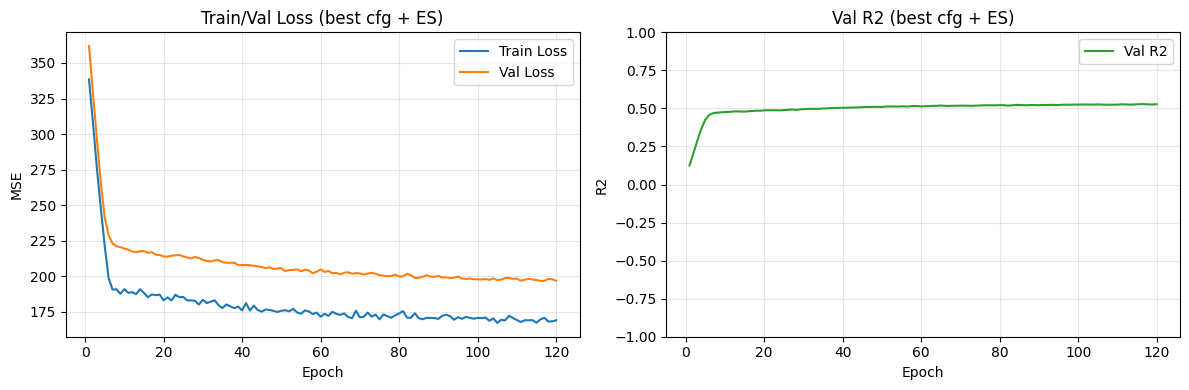

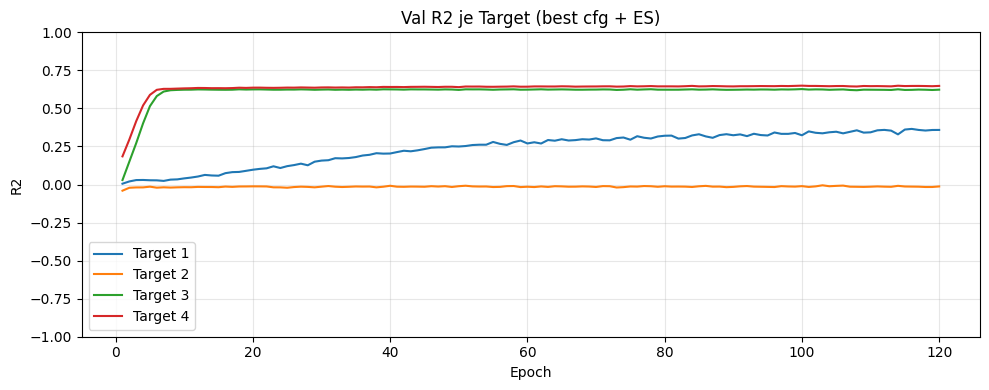

In [43]:
# Early-Stopping-Training mit LR-Decay und per-Target-R²
def train_with_early_stopping_reg(X_tr, y_tr, X_val, y_val, cfg, seed=777, patience=10, lr_decay_factor=0.5, lr_decay_patience=8):
    np.random.seed(seed)
    mu, sigma = standardize_fit(X_tr)
    X_tr_s = standardize_apply(X_tr,  mu, sigma)
    X_val_s= standardize_apply(X_val, mu, sigma)
    model = build_model(X_tr_s.shape[1], cfg['hidden_sizes'], y_tr.shape[1])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=cfg['learning_rate'], weight_decay=cfg['weight_decay'])
    train_loader = make_loader(X_tr_s,  y_tr,  batch_size=cfg['batch_size'], shuffle=True)
    val_loader   = make_loader(X_val_s, y_val, batch_size=cfg['batch_size'], shuffle=False)
    tr_hist, va_hist, r2_hist = [], [], []
    r2_targets_hist = []  # Liste je Epoche mit R² pro Target
    best_val = float('inf')
    best_state = None
    epochs_no_improve = 0
    epochs_no_lr_improve = 0
    current_lr = cfg['learning_rate']
    for ep in range(cfg['num_epochs']):
        # Train
        t_losses = []
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()
            t_losses.append(l)
        # Val
        v_losses = []
        preds, trues = [], []
        for xb, yb in val_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            v_losses.append(l)
            preds.append(yp); trues.append(yb)
        tr_hist.append(float(np.mean(t_losses)))
        val_mean = float(np.mean(v_losses))
        va_hist.append(val_mean)
        p_full = np.concatenate(preds, axis=0)
        t_full = np.concatenate(trues, axis=0)
        r2_hist.append(r2_score_np(t_full, p_full))
        # per-target R²
        r2_targets = []
        for i in range(t_full.shape[1]):
            r2_targets.append(r2_score_np(t_full[:, i:i+1], p_full[:, i:i+1]))
        r2_targets_hist.append(r2_targets)
        # Early Stopping
        if val_mean < best_val - 1e-6:
            best_val = val_mean
            # Einfacher "State": wir speichern Model-Objekt-Referenz kopfseitig (hier genügt Referenz, da wir direkt weitertrainieren)
            best_state = (model, mu, sigma)
            epochs_no_improve = 0
            epochs_no_lr_improve = 0
        else:
            epochs_no_improve += 1
            epochs_no_lr_improve += 1
        # LR-Decay
        if epochs_no_lr_improve >= lr_decay_patience:
            current_lr *= lr_decay_factor
            optimizer.learning_rate = current_lr
            epochs_no_lr_improve = 0
        # Stoppen
        if epochs_no_improve >= patience:
            break
    # Falls kein best_state gesetzt wurde, nimm aktuelles
    if best_state is None:
        best_state = (model, mu, sigma)
    return {
        'model': best_state[0],
        'mu_sigma': (best_state[1], best_state[2]),
        'train_loss_history': tr_hist,
        'val_loss_history': va_hist,
        'val_r2_history': r2_hist,
        'val_r2_targets_history': r2_targets_hist,
    }

# Demo: verwende best_cfg und denselben Outer-Split wie zuvor, aber mit Early Stopping
if len(outer_results) > 0:
    best_cfg = outer_results[0]['best_cfg']
    test_idx = outer_folds[0]
    trainval_idx = np.concatenate([outer_folds[j] for j in range(k_outer) if j != 0])
    X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
    X_test_o,   y_test_o   = X[test_idx],     y[test_idx]
    hist_es = train_with_early_stopping_reg(X_trainval, y_trainval, X_test_o, y_test_o, best_cfg, seed=2026, patience=12, lr_decay_factor=0.5, lr_decay_patience=10)
    epochs = np.arange(1, len(hist_es['train_loss_history'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist_es['train_loss_history'], label='Train Loss')
    plt.plot(epochs, hist_es['val_loss_history'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Train/Val Loss (best cfg + ES)'); plt.grid(alpha=0.3); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hist_es['val_r2_history'], color='tab:green', label='Val R2')
    plt.xlabel('Epoch'); plt.ylabel('R2'); plt.title('Val R2 (best cfg + ES)'); plt.ylim(-1.0, 1.0); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()
    # Per-Target R² Verlauf (als kleine Übersicht)
    r2_targets_hist = np.array(hist_es['val_r2_targets_history'])  # shape: (epochs, n_targets)
    if r2_targets_hist.size > 0:
        plt.figure(figsize=(10,4))
        for i in range(r2_targets_hist.shape[1]):
            plt.plot(np.arange(1, r2_targets_hist.shape[0]+1), r2_targets_hist[:, i], label=f'Target {i+1}')
        plt.xlabel('Epoch'); plt.ylabel('R2'); plt.title('Val R2 je Target (best cfg + ES)'); plt.ylim(-1.0, 1.0); plt.grid(alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()
else:
    print('Bitte zuerst die Nested-CV-Zelle ausführen, damit outer_results verfügbar ist.')

## Inferenz auf dem Blind-Testset (ML-CUP25-TS.csv)
Diese Zelle lädt das Blind-Testset und berechnet Vorhersagen mit dem besten Modell aus der Nested-CV.
Hinweise:
- Das TS-Set enthält keine Targets; wir erzeugen nur `y_pred`.
- Standardisierung: verwendet die `mu/sigma` aus dem finalen Training des besten Modells (kein Leakage).
- Optional: Speichern der Predictions als CSV mit den zugehörigen IDs.

In [44]:
# Laden des Blind-Testsets
df_ts = pd.read_csv('ML-CUP25-TS.csv', header=None, comment='#')
ID_ts = df_ts.iloc[:, 0].to_numpy()
X_ts  = df_ts.iloc[:, 1:].astype(np.float32).to_numpy()
print('TS shapes:', ID_ts.shape, X_ts.shape)

# Inferenz mit best_cfg und erneut trainiertem Modell
if len(outer_results) > 0:
    # Nimm die beste Konfiguration aus dem ersten Outer-Fold (oder wähle die mit bestem Test-R2)
    # Hier exemplarisch die mit maximalem Test-R2 über alle Outer-Folds:
    best_idx = int(np.argmax([r['test_r2'] for r in outer_results]))
    best_cfg = outer_results[best_idx]['best_cfg']
    print('Verwende best_cfg aus Outer-Fold', best_idx+1, ':', best_cfg)
    
    # Trainiere final auf dem gesamten Trainingsdatensatz (X, y) mit Standardisierung
    mu, sigma = standardize_fit(X)
    X_s = standardize_apply(X,  mu, sigma)
    X_ts_s = standardize_apply(X_ts, mu, sigma)
    model = build_model(X_s.shape[1], best_cfg['hidden_sizes'], y.shape[1])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=best_cfg['learning_rate'], weight_decay=best_cfg['weight_decay'])
    train_loader = make_loader(X_s, y, batch_size=best_cfg['batch_size'], shuffle=True)
    for _ in range(best_cfg['num_epochs']):
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()
    
    # Vorhersagen auf TS
    preds_ts = []
    # großer Batch ist okay (hier 256)
    ts_loader = make_loader(X_ts_s, np.zeros((X_ts_s.shape[0], y.shape[1]), dtype=np.float32), batch_size=256, shuffle=False)
    for xb, _ in ts_loader:
        yp = model.forward(xb)
        preds_ts.append(yp)
    Y_ts_pred = np.concatenate(preds_ts, axis=0)
    print('Y_ts_pred shape:', Y_ts_pred.shape)
    
    # Speichern als CSV: ID und vier Targets
    out = pd.DataFrame(Y_ts_pred, columns=[f'TARGET_{i+1}' for i in range(Y_ts_pred.shape[1])])
    out.insert(0, 'ID', ID_ts)
    out.to_csv('ML-CUP25-TS-predictions.csv', index=False)
    print('Predictions gespeichert in ML-CUP25-TS-predictions.csv')
else:
    print('Bitte erst Nested-CV ausführen, damit outer_results/best_cfg verfügbar sind.')

TS shapes: (1000,) (1000, 12)
Verwende best_cfg aus Outer-Fold 4 : {'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120}
Y_ts_pred shape: (1000, 4)
Predictions gespeichert in ML-CUP25-TS-predictions.csv
Y_ts_pred shape: (1000, 4)
Predictions gespeichert in ML-CUP25-TS-predictions.csv
